# Klasifikasi Jenis Batik Cap / Tulis


## Kelompok 1 - TI 3G

Nama Anggota Kelompok:
1. Aditya Atadewa (2341720174)
2. Ahmad Naufal Ilham (2341720047)
3. Aril Ibbet Ardana Putra (2341720095)
4. Chiko Abilla Basya (2341720005)
5. Diana Rahmawati (2341720162)

## 0) Mount Google Drive

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False
    print("Not running in Google Colab. Drive mount skipped.")

Mounted at /content/drive


## 1) Setup: Import, Seed, Device, dan Path

Path Dataset:
- `ML_Kelompok_1/dataset/tulis`
- `ML_Kelompok_1/dataset/cap`

In [ ]:
import os
import random
import shutil
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# ========= Seed =========
BASE_SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(BASE_SEED)

# ========= Device =========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ========= Paths =========
# Default path untuk Colab:
DRIVE_ROOT = Path("/content/drive/MyDrive") if IN_COLAB else Path.cwd()

PROJECT_ROOT = DRIVE_ROOT / "ML_Kelompok_1"
RAW_DATA_DIR = PROJECT_ROOT / "dataset"              # /tulis dan /cap
PROCESSED_DIR = PROJECT_ROOT / "processed_ml"        # semua output ML di sini

RESIZE_DIR = PROCESSED_DIR / "resize"
SPLIT_DIR  = PROCESSED_DIR / "ml_split_images"       # train/val/test image-level
PATCH_DIR  = PROCESSED_DIR / "ml_split_patches"      # train/val/test patch-level
MODEL_DIR  = PROCESSED_DIR / "models"
RESULT_DIR = PROCESSED_DIR / "results"

# Create folders if not exist
for p in [PROCESSED_DIR, RESIZE_DIR, SPLIT_DIR, PATCH_DIR, MODEL_DIR, RESULT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

CLASS_NAMES = ["tulis", "cap"]  # sesuai folder dataset kamu

print("RAW_DATA_DIR:", RAW_DATA_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)

Device: cuda
RAW_DATA_DIR: /content/drive/MyDrive/ML_Kelompok_1/dataset
PROCESSED_DIR: /content/drive/MyDrive/ML_Kelompok_1/processed_ml


## 2) Cek Dataset (jumlah gambar per kelas)

In [ ]:
def list_images(folder: Path, exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")) -> List[Path]:
    if not folder.exists():
        return []
    return sorted([p for p in folder.rglob("*") if p.suffix.lower() in exts])

raw_counts = {}
raw_files: Dict[str, List[Path]] = {}

for cls in CLASS_NAMES:
    files = list_images(RAW_DATA_DIR / cls)
    raw_files[cls] = files
    raw_counts[cls] = len(files)

display(pd.DataFrame([raw_counts]))

missing = [cls for cls in CLASS_NAMES if raw_counts[cls] == 0]
if missing:
    raise FileNotFoundError(
        f"Folder kosong/tidak ditemukan untuk kelas: {missing}\n"
        f"Pastikan struktur: {RAW_DATA_DIR}/tulis dan {RAW_DATA_DIR}/cap berisi gambar."
    )

for cls in CLASS_NAMES:
    print(cls, "contoh file:", raw_files[cls][:3])

,tulis,cap
0,48,48


tulis contoh file: [PosixPath('/content/drive/MyDrive/ML_Kelompok_1/dataset/tulis/Copy of IMG_2822.JPG'), PosixPath('/content/drive/MyDrive/ML_Kelompok_1/dataset/tulis/Copy of IMG_2825.JPG'), PosixPath('/content/drive/MyDrive/ML_Kelompok_1/dataset/tulis/Copy of IMG_2826.JPG')]
cap contoh file: [PosixPath('/content/drive/MyDrive/ML_Kelompok_1/dataset/cap/Copy of Batik Cap 3 Warna Bunga Orange_18.JPG'), PosixPath('/content/drive/MyDrive/ML_Kelompok_1/dataset/cap/Copy of Batik Cap 3 Warna Bunga Orange_2.JPG'), PosixPath('/content/drive/MyDrive/ML_Kelompok_1/dataset/cap/Copy of Batik Cap 3 Warna Bunga Orange_3.JPG')]


## 3) Resize (540×630)


In [ ]:
TARGET_W, TARGET_H = 540, 630
OVERWRITE_RESIZE = False  # True jika ingin resize ulang

def resize_and_save(in_path: Path, out_path: Path, size=(540, 630)):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with Image.open(in_path) as img:
        img = img.convert("RGB")

        img = img.resize(size, resample=Image.BILINEAR)
        img.save(out_path, format="JPEG", quality=95)

for cls in CLASS_NAMES:
    out_dir = RESIZE_DIR / cls
    out_dir.mkdir(parents=True, exist_ok=True)

    for fp in list_images(RAW_DATA_DIR / cls):
        out_fp = out_dir / f"{fp.stem}.jpg"
        if out_fp.exists() and not OVERWRITE_RESIZE:
            continue
        resize_and_save(fp, out_fp, size=(TARGET_W, TARGET_H))

resize_counts = {cls: len(list_images(RESIZE_DIR / cls)) for cls in CLASS_NAMES}
display(pd.DataFrame([resize_counts]))

,tulis,cap
0,48,48


## 4) Buat 5 Variasi Split (Train/Val/Test) di Level Gambar
Split seimbang per kelas (dataset 48/48):
- 30/9/9
- 32/8/8
- 34/7/7
- 36/6/6
- 38/5/5

Seed dibuat berbeda per variasi agar benar-benar variasi.

In [ ]:
# 5 variasi split per kelas: (train, val, test)
SPLIT_VARIANTS: List[Tuple[int,int,int]] = [
    (30, 9, 9),
    (32, 8, 8),
    (34, 7, 7),
    (36, 6, 6),
    (38, 5, 5),
]

OVERWRITE_SPLITS = False  # True untuk regenerate split folder

def clear_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def make_split_for_variant(variant: Tuple[int,int,int], seed: int):
    tr_n, va_n, te_n = variant
    variant_name = f"split_{tr_n}_{va_n}_{te_n}"
    out_base = SPLIT_DIR / variant_name

    if out_base.exists() and not OVERWRITE_SPLITS:
        print(f"[SKIP] {variant_name} sudah ada. Set OVERWRITE_SPLITS=True untuk ulang.")
        return variant_name

    clear_dir(out_base)

    # Prepare subfolders
    for split in ["train", "val", "test"]:
        for cls in CLASS_NAMES:
            (out_base / split / cls).mkdir(parents=True, exist_ok=True)

    rng = random.Random(seed)

    # Split per kelas agar balance
    for cls in CLASS_NAMES:
        cls_files = list_images(RESIZE_DIR / cls)
        need = tr_n + va_n + te_n
        if len(cls_files) < need:
            raise ValueError(f"Kelas '{cls}' hanya punya {len(cls_files)} gambar, butuh {need}.")

        cls_files = cls_files.copy()
        rng.shuffle(cls_files)

        train_files = cls_files[:tr_n]
        val_files   = cls_files[tr_n:tr_n + va_n]
        test_files  = cls_files[tr_n + va_n:tr_n + va_n + te_n]

        for fp in train_files:
            shutil.copy2(fp, out_base / "train" / cls / fp.name)
        for fp in val_files:
            shutil.copy2(fp, out_base / "val" / cls / fp.name)
        for fp in test_files:
            shutil.copy2(fp, out_base / "test" / cls / fp.name)

    print(f"[OK] Created image-level split: {variant_name}")
    return variant_name

variant_names = []
for i, var in enumerate(SPLIT_VARIANTS):
    variant_names.append(make_split_for_variant(var, seed=BASE_SEED + i))

# Sanity check counts
rows = []
for vn, var in zip(variant_names, SPLIT_VARIANTS):
    row = {"variant": vn, "per_class_train": var[0], "per_class_val": var[1], "per_class_test": var[2]}
    for split in ["train","val","test"]:
        for cls in CLASS_NAMES:
            row[f"{split}_{cls}"] = len(list_images(SPLIT_DIR / vn / split / cls))
    rows.append(row)

display(pd.DataFrame(rows))

[SKIP] split_30_9_9 sudah ada. Set OVERWRITE_SPLITS=True untuk ulang.
[SKIP] split_32_8_8 sudah ada. Set OVERWRITE_SPLITS=True untuk ulang.
[SKIP] split_34_7_7 sudah ada. Set OVERWRITE_SPLITS=True untuk ulang.
[SKIP] split_36_6_6 sudah ada. Set OVERWRITE_SPLITS=True untuk ulang.
[SKIP] split_38_5_5 sudah ada. Set OVERWRITE_SPLITS=True untuk ulang.


,variant,per_class_train,per_class_val,per_class_test,train_tulis,train_cap,val_tulis,val_cap,test_tulis,test_cap
0,split_30_9_9,30,9,9,30,30,9,9,9,9
1,split_32_8_8,32,8,8,32,32,8,8,8,8
2,split_34_7_7,34,7,7,34,34,7,7,7,7
3,split_36_6_6,36,6,6,36,36,6,6,6,6
4,split_38_5_5,38,5,5,38,38,5,5,5,5


## 5) Patching 30 Patch per Gambar

- BLOCK_SIZE=90
- PATCH_SIZE=180 (2×2 block)
- Output 30 patch per gambar.

In [ ]:
BLOCK_SIZE = 90
PATCH_SIZE = 180
OVERWRITE_PATCHES = False  # True untuk regenerate patch

def extract_30_patches(img_path: Path) -> List[Image.Image]:
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        w, h = img.size

        blocks_x = w // BLOCK_SIZE  # 540//90 = 6
        blocks_y = h // BLOCK_SIZE  # 630//90 = 7

        patches = []
        for by in range(blocks_y - 1):
            for bx in range(blocks_x - 1):
                left = bx * BLOCK_SIZE
                upper = by * BLOCK_SIZE
                right = left + PATCH_SIZE
                lower = upper + PATCH_SIZE
                patches.append(img.crop((left, upper, right, lower)))
        return patches

def patch_split_variant(variant_name: str):
    in_base = SPLIT_DIR / variant_name
    out_base = PATCH_DIR / variant_name

    if out_base.exists() and not OVERWRITE_PATCHES:
        print(f"[SKIP] Patches untuk {variant_name} sudah ada. Set OVERWRITE_PATCHES=True untuk ulang.")
        return

    if out_base.exists():
        shutil.rmtree(out_base)
    out_base.mkdir(parents=True, exist_ok=True)

    for split in ["train", "val", "test"]:
        for cls in CLASS_NAMES:
            in_dir = in_base / split / cls
            out_dir = out_base / split / cls
            out_dir.mkdir(parents=True, exist_ok=True)

            img_files = list_images(in_dir)
            for img_fp in img_files:
                patches = extract_30_patches(img_fp)
                if len(patches) != 30:
                    raise RuntimeError(f"Patch count != 30 untuk {img_fp} (got {len(patches)})")

                for idx, pimg in enumerate(patches, start=1):
                    out_name = f"{img_fp.stem}_patch_{idx:02d}.jpg"
                    out_fp = out_dir / out_name
                    if out_fp.exists() and not OVERWRITE_PATCHES:
                        continue
                    pimg.save(out_fp, format="JPEG", quality=95)

    print(f"[OK] Created patch dataset for {variant_name}")

for vn in variant_names:
    patch_split_variant(vn)

# Check patch counts
rows = []
for vn in variant_names:
    row = {"variant": vn}
    for split in ["train","val","test"]:
        for cls in CLASS_NAMES:
            row[f"{split}_{cls}"] = len(list_images(PATCH_DIR / vn / split / cls))
    rows.append(row)

display(pd.DataFrame(rows))

[SKIP] Patches untuk split_30_9_9 sudah ada. Set OVERWRITE_PATCHES=True untuk ulang.
[SKIP] Patches untuk split_32_8_8 sudah ada. Set OVERWRITE_PATCHES=True untuk ulang.
[SKIP] Patches untuk split_34_7_7 sudah ada. Set OVERWRITE_PATCHES=True untuk ulang.
[SKIP] Patches untuk split_36_6_6 sudah ada. Set OVERWRITE_PATCHES=True untuk ulang.
[SKIP] Patches untuk split_38_5_5 sudah ada. Set OVERWRITE_PATCHES=True untuk ulang.


,variant,train_tulis,train_cap,val_tulis,val_cap,test_tulis,test_cap
0,split_30_9_9,900,900,270,270,270,270
1,split_32_8_8,960,960,240,240,240,240
2,split_34_7_7,1020,1020,210,210,210,210
3,split_36_6_6,1080,1080,180,180,180,180
4,split_38_5_5,1140,1140,150,150,150,150


### Preview contoh patch (train/val/test)
Cell ini menampilkan beberapa patch acak dari folder patch untuk memastikan hasil patching sudah benar.

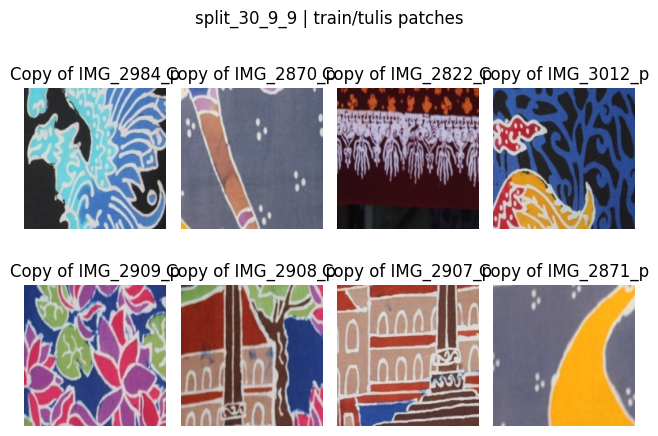

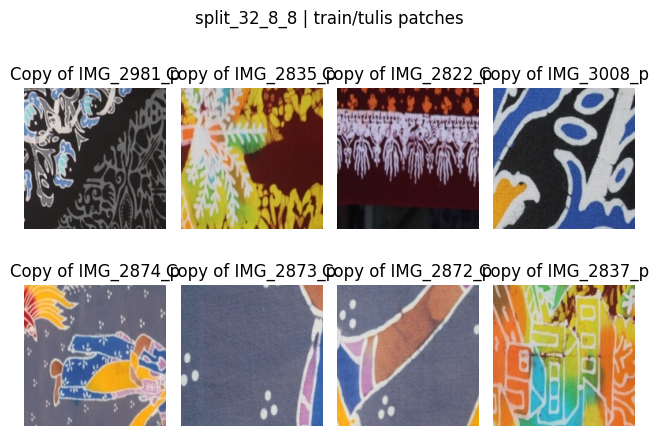

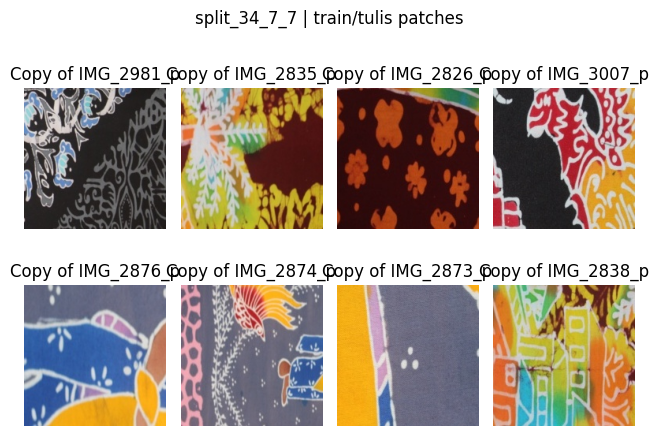

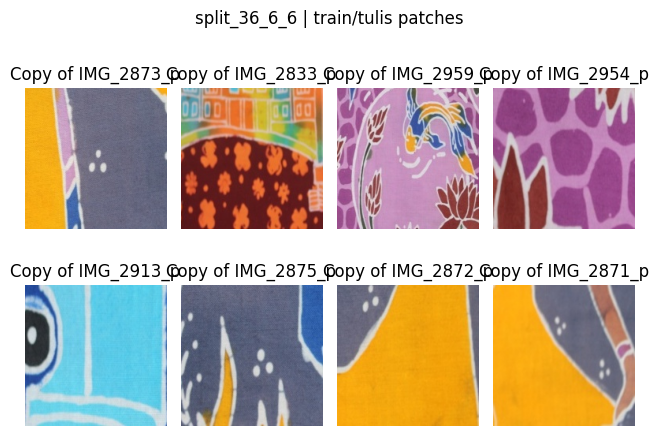

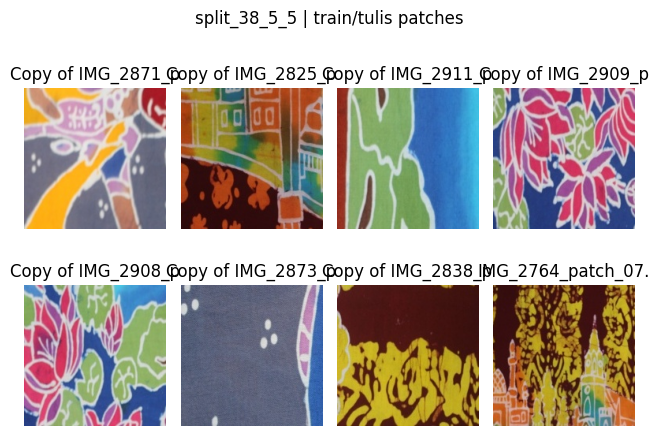

In [ ]:
import math
from PIL import Image
import matplotlib.pyplot as plt

def show_random_patches(variant_name, split="train", cls="tulis", n=12, seed=42):
    rng = random.Random(seed)
    folder = PATCH_DIR / variant_name / split / cls
    files = list_images(folder)
    if len(files) == 0:
        print("No files:", folder)
        return

    picks = rng.sample(files, k=min(n, len(files)))
    cols = 4
    rows = math.ceil(len(picks) / cols)

    plt.figure()
    for i, fp in enumerate(picks, 1):
        img = Image.open(fp).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fp.name[:18])
    plt.suptitle(f"{variant_name} | {split}/{cls} patches")
    plt.tight_layout()
    plt.show()

# Contoh: preview patch train untuk tiap split (kelas tulis).
for vn in variant_names:
    show_random_patches(vn, split="train", cls="tulis", n=8, seed=BASE_SEED)

## 6) DataLoader + Transform
Train menggunakan augmentasi ringan; val/test tanpa augmentasi.

In [ ]:
# Hyperparameters (silakan ubah)
BATCH_SIZE = 64
NUM_WORKERS = 2
EPOCHS = 15
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 5  # early stopping patience

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

def make_loaders(variant_name: str):
    base = PATCH_DIR / variant_name
    train_ds = datasets.ImageFolder(base / "train", transform=train_tfms)
    val_ds   = datasets.ImageFolder(base / "val",   transform=eval_tfms)
    test_ds  = datasets.ImageFolder(base / "test",  transform=eval_tfms)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

# Sanity check
train_ds, val_ds, test_ds, *_ = make_loaders(variant_names[0])
print("class_to_idx:", train_ds.class_to_idx)
print("train/val/test size:", len(train_ds), len(val_ds), len(test_ds))

class_to_idx: {'cap': 0, 'tulis': 1}
train/val/test size: 1800 540 540


## 7) Model: VGG13_bn Transfer Learning (2 kelas)
Freeze feature extractor, train classifier.

In [ ]:
def build_model(num_classes: int = 2):
    weights = models.VGG13_BN_Weights.DEFAULT
    model = models.vgg13_bn(weights=weights)

    # Freeze backbone
    for p in model.features.parameters():
        p.requires_grad = False

    # Replace last layer
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

    return model.to(DEVICE)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

class EarlyStopping:
    def __init__(self, patience=5, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.counter = 0
        self.best_state = None

    def step(self, metric, model):
        improved = False
        if self.best is None:
            improved = True
        else:
            improved = (metric > self.best) if self.mode == "max" else (metric < self.best)

        if improved:
            self.best = metric
            self.counter = 0
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1

        return self.counter >= self.patience

## 8) Training + Evaluasi per Variasi Split
Output:
- Model terbaik per split disimpan ke `processed_ml/models/`
- Rekap hasil disimpan ke `processed_ml/results/`

In [ ]:
@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()
        ys.append(y.numpy())
        ps.append(pred)
    return np.concatenate(ys), np.concatenate(ps)

def run_experiment(variant_name: str):
    seed_everything(BASE_SEED)  # keep training reproducible

    train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = make_loaders(variant_name)
    idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}

    model = build_model(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)

    es = EarlyStopping(patience=PATIENCE, mode="max")
    history = []

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)

        history.append({
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": va_loss,
            "val_acc": va_acc,
        })

        print(f"[{variant_name}] Epoch {epoch:02d}/{EPOCHS} | "
              f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
              f"val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

        if es.step(va_acc, model):
            print(f"[{variant_name}] Early stopping triggered.")
            break

    # Load best model state
    if es.best_state is not None:
        model.load_state_dict(es.best_state)

    # Save best model
    model_path = MODEL_DIR / f"{variant_name}_best.pth"
    torch.save(model.state_dict(), model_path)

    # Evaluate on test
    y_true, y_pred = predict_all(model, test_loader)
    test_acc = float(accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)

    report = classification_report(
        y_true, y_pred,
        target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
        output_dict=True,
        zero_division=0
    )

    # Flatten report summary
    result = {
        "variant": variant_name,
        "best_val_acc": float(max([h["val_acc"] for h in history])) if history else None,
        "test_acc": test_acc,
        "model_path": str(model_path),
        "train_patches": len(train_ds),
        "val_patches": len(val_ds),
        "test_patches": len(test_ds),
        "confusion_matrix": cm,
        "history": history,
        "report": report,
    }

    return result

all_results = []
for vn in variant_names:
    res = run_experiment(vn)
    all_results.append(res)

print("Done.")

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


100%|██████████| 508M/508M [00:06<00:00, 81.8MB/s]


[split_30_9_9] Epoch 01/15 | train_loss=0.5792 train_acc=0.7844 | val_loss=0.4071 val_acc=0.8741
[split_30_9_9] Epoch 02/15 | train_loss=0.1616 train_acc=0.9450 | val_loss=0.5432 val_acc=0.8778
[split_30_9_9] Epoch 03/15 | train_loss=0.0998 train_acc=0.9672 | val_loss=1.0917 val_acc=0.8463
[split_30_9_9] Epoch 04/15 | train_loss=0.0950 train_acc=0.9728 | val_loss=0.8694 val_acc=0.8704
[split_30_9_9] Epoch 05/15 | train_loss=0.1094 train_acc=0.9722 | val_loss=0.9334 val_acc=0.9019
[split_30_9_9] Epoch 06/15 | train_loss=0.0937 train_acc=0.9822 | val_loss=1.0096 val_acc=0.8685
[split_30_9_9] Epoch 07/15 | train_loss=0.1697 train_acc=0.9678 | val_loss=1.7753 val_acc=0.8593
[split_30_9_9] Epoch 08/15 | train_loss=0.1016 train_acc=0.9744 | val_loss=0.8122 val_acc=0.9204
[split_30_9_9] Epoch 09/15 | train_loss=0.1659 train_acc=0.9717 | val_loss=1.4652 val_acc=0.8722
[split_30_9_9] Epoch 10/15 | train_loss=0.1136 train_acc=0.9783 | val_loss=1.5769 val_acc=0.8759
[split_30_9_9] Epoch 11/15 | t

## 9) Visualisasi & Rekap Hasil
Menampilkan tabel ringkas + plot kurva loss/acc untuk tiap split.

,variant,train_patches,val_patches,test_patches,best_val_acc,test_acc,model_path
4,split_38_5_5,2280,300,300,0.986667,0.996667,/content/drive/MyDrive/ML_Kelompok_1/processed...
2,split_34_7_7,2040,420,420,0.997619,0.985714,/content/drive/MyDrive/ML_Kelompok_1/processed...
0,split_30_9_9,1800,540,540,0.920370,0.962963,/content/drive/MyDrive/ML_Kelompok_1/processed...
1,split_32_8_8,1920,480,480,0.991667,0.950000,/content/drive/MyDrive/ML_Kelompok_1/processed...
3,split_36_6_6,2160,360,360,0.980556,0.905556,/content/drive/MyDrive/ML_Kelompok_1/processed...


Saved: /content/drive/MyDrive/ML_Kelompok_1/processed_ml/results/summary_results.csv


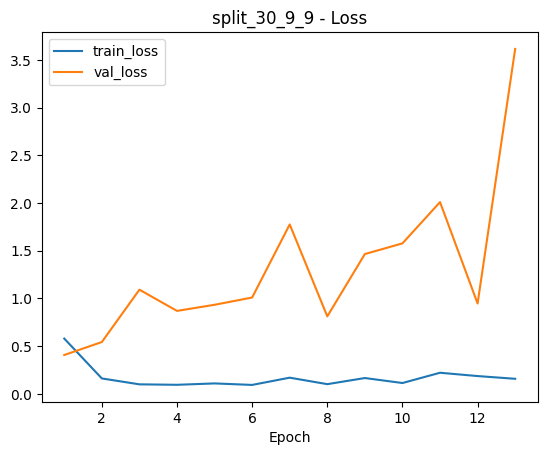

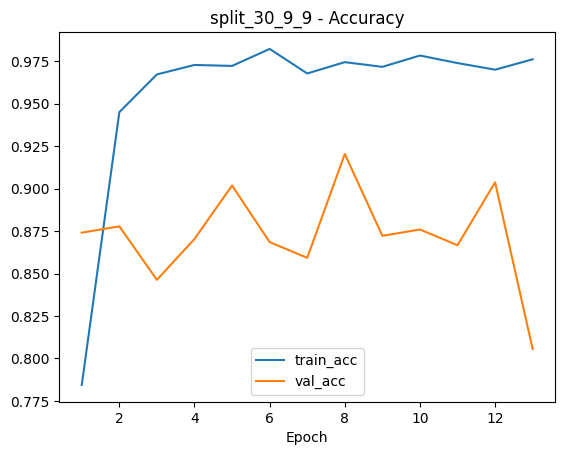

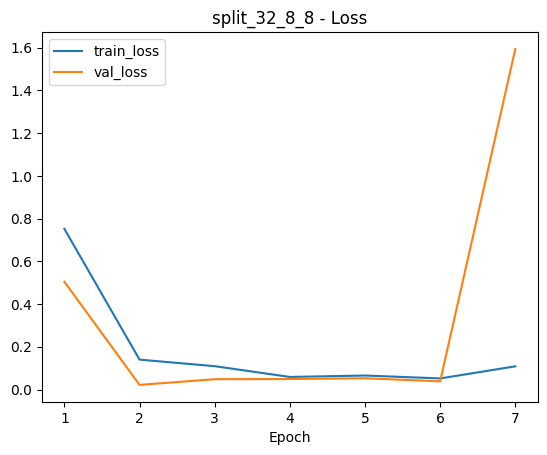

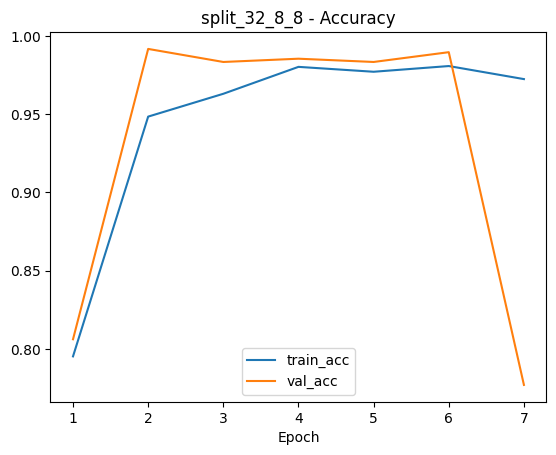

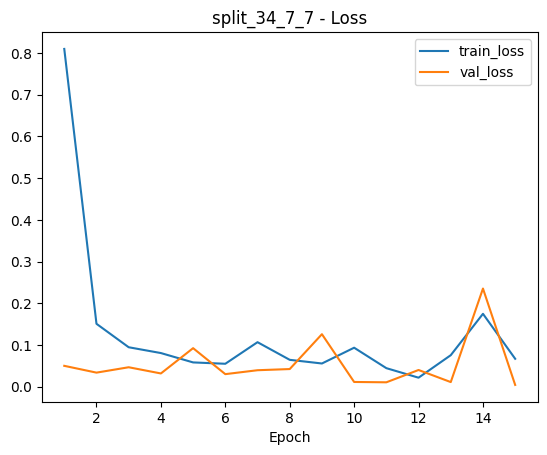

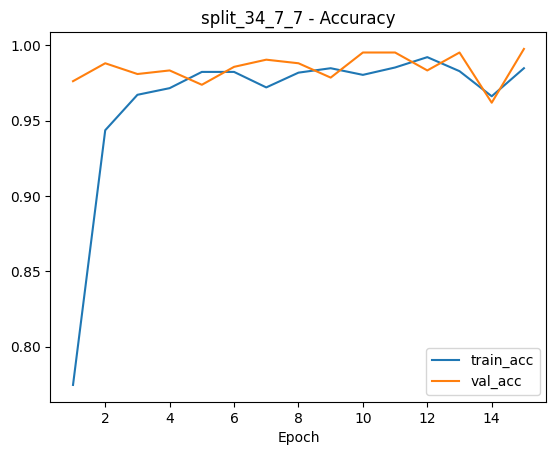

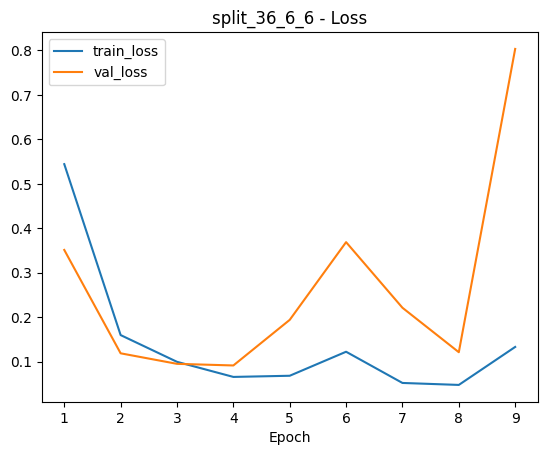

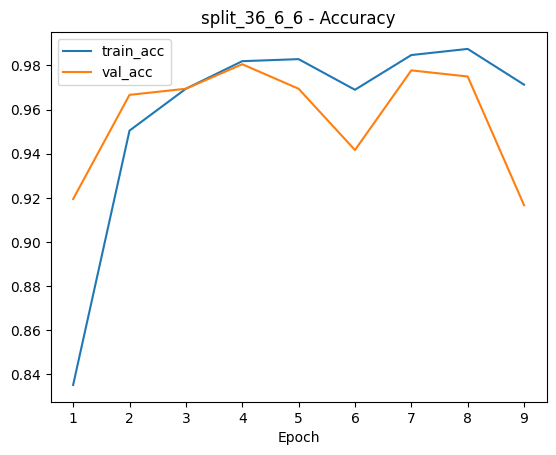

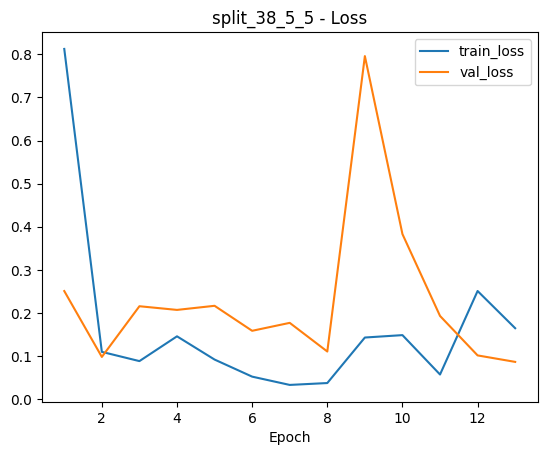

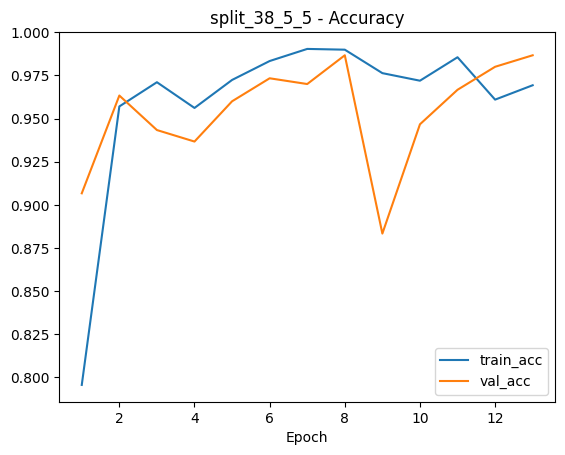

In [ ]:
# Summary table
summary_rows = []
for r in all_results:
    summary_rows.append({
        "variant": r["variant"],
        "train_patches": r["train_patches"],
        "val_patches": r["val_patches"],
        "test_patches": r["test_patches"],
        "best_val_acc": r["best_val_acc"],
        "test_acc": r["test_acc"],
        "model_path": r["model_path"],
    })

df_summary = pd.DataFrame(summary_rows).sort_values("test_acc", ascending=False)
display(df_summary)

# Save summary
summary_csv = RESULT_DIR / "summary_results.csv"
df_summary.to_csv(summary_csv, index=False)
print("Saved:", summary_csv)

def plot_history(history, title):
    dfh = pd.DataFrame(history)
    if dfh.empty:
        return
    plt.figure()
    plt.plot(dfh["epoch"], dfh["train_loss"], label="train_loss")
    plt.plot(dfh["epoch"], dfh["val_loss"], label="val_loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(dfh["epoch"], dfh["train_acc"], label="train_acc")
    plt.plot(dfh["epoch"], dfh["val_acc"], label="val_acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

for r in all_results:
    plot_history(r["history"], r["variant"])

### Komparasi akurasi antar split
Grafik perbandingan  **test accuracy** antar variasi split.

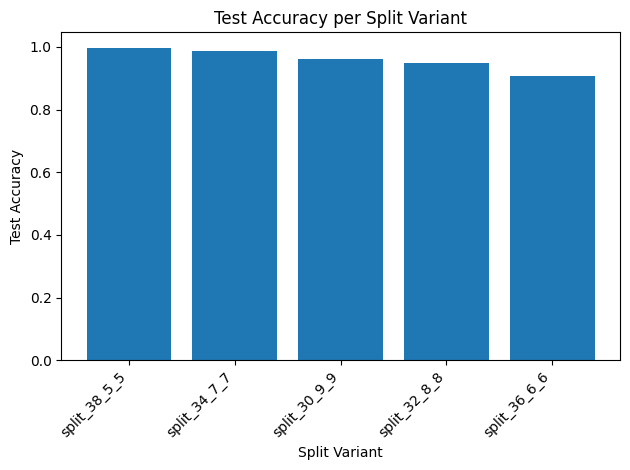

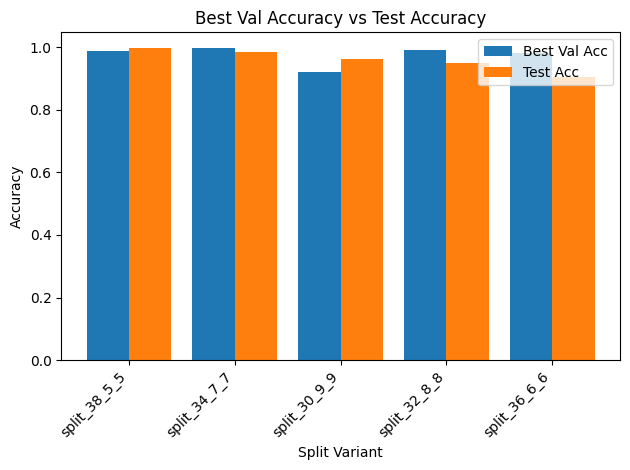

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart test accuracy per split
plt.figure()
plt.bar(df_summary["variant"], df_summary["test_acc"])
plt.xticks(rotation=45, ha="right")
plt.title("Test Accuracy per Split Variant")
plt.xlabel("Split Variant")
plt.ylabel("Test Accuracy")
plt.tight_layout()
plt.show()

# (Opsional) Bandingkan best val vs test
plt.figure()
x = np.arange(len(df_summary))
plt.bar(x - 0.2, df_summary["best_val_acc"], width=0.4, label="Best Val Acc")
plt.bar(x + 0.2, df_summary["test_acc"], width=0.4, label="Test Acc")
plt.xticks(x, df_summary["variant"], rotation=45, ha="right")
plt.title("Best Val Accuracy vs Test Accuracy")
plt.xlabel("Split Variant")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## 10) Confusion Matrix & Classification Report (per Split)

In [ ]:
for r in all_results:
    print("="*80)
    print("Variant:", r["variant"])
    print("Test Accuracy:", r["test_acc"])
    print("Confusion Matrix:\n", r["confusion_matrix"])

    # Pretty classification report
    rep_df = pd.DataFrame(r["report"]).T
    display(rep_df)

Variant: split_30_9_9
Test Accuracy: 0.9629629629629629
Confusion Matrix:
 [[269   1]
 [ 19 251]]


,precision,recall,f1-score,support
cap,0.934028,0.996296,0.964158,270.000000
tulis,0.996032,0.929630,0.961686,270.000000
accuracy,0.962963,0.962963,0.962963,0.962963
macro avg,0.965030,0.962963,0.962922,540.000000
weighted avg,0.965030,0.962963,0.962922,540.000000


Variant: split_32_8_8
Test Accuracy: 0.95
Confusion Matrix:
 [[216  24]
 [  0 240]]


,precision,recall,f1-score,support
cap,1.000000,0.90,0.947368,240.00
tulis,0.909091,1.00,0.952381,240.00
accuracy,0.950000,0.95,0.950000,0.95
macro avg,0.954545,0.95,0.949875,480.00
weighted avg,0.954545,0.95,0.949875,480.00


Variant: split_34_7_7
Test Accuracy: 0.9857142857142858
Confusion Matrix:
 [[207   3]
 [  3 207]]


,precision,recall,f1-score,support
cap,0.985714,0.985714,0.985714,210.000000
tulis,0.985714,0.985714,0.985714,210.000000
accuracy,0.985714,0.985714,0.985714,0.985714
macro avg,0.985714,0.985714,0.985714,420.000000
weighted avg,0.985714,0.985714,0.985714,420.000000


Variant: split_36_6_6
Test Accuracy: 0.9055555555555556
Confusion Matrix:
 [[149  31]
 [  3 177]]


,precision,recall,f1-score,support
cap,0.980263,0.827778,0.897590,180.000000
tulis,0.850962,0.983333,0.912371,180.000000
accuracy,0.905556,0.905556,0.905556,0.905556
macro avg,0.915612,0.905556,0.904981,360.000000
weighted avg,0.915612,0.905556,0.904981,360.000000


Variant: split_38_5_5
Test Accuracy: 0.9966666666666667
Confusion Matrix:
 [[150   0]
 [  1 149]]


,precision,recall,f1-score,support
cap,0.993377,1.000000,0.996678,150.000000
tulis,1.000000,0.993333,0.996656,150.000000
accuracy,0.996667,0.996667,0.996667,0.996667
macro avg,0.996689,0.996667,0.996667,300.000000
weighted avg,0.996689,0.996667,0.996667,300.000000
